Building the model:

Our model is constructed using the Modelbase software. For that, a dictionary including the parameters is created and passed to the model object. After declaring the compounds of the model, all reactions are introduced using corresponding stoichiometries and functions representing their rate equations.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.optimize
from modelbase.ode import Model, LabelModel, LinearLabelModel, Simulator, mca




#Defining the parameterset
defP = {'SL_D14_TO': 1.58533423e+01,#0.005
             
  'SL_SMXL6_TO': 4.02114432e-01,
    
  'SL_eff': 1.00000000e-03,
 
  'SL_ka': 1.00000000e-03,

  'SL_lm': 4.08586935e+01,
 
'recycle': 1.56663361e+01,#0.03

'turnover':4.83259518e+01,
'SL_inf':0.01

} 


#initiating the model object


m = Model()
m.add_parameters(defP)


#adding compound IDs
        
m.add_compounds(['SL','D14','SMXL6','SL_D14'])

#adding all reactions


def SL_Influx(SL_inf):

    return SL_inf



m.add_reaction(
    rate_name="SL_Influx",
    function=SL_Influx,
    stoichiometry=({'SL':1}),
    parameters=["SL_inf"],
)



def SL_Efflux(SL,SL_eff):
    return SL_eff*SL

m.add_reaction(
    rate_name="SL_Efflux",
    function=SL_Efflux,
    stoichiometry=({'SL':-1}),
    parameters=["SL_eff"],
)




def SL_ka(SL,D14,SL_ka):
    return SL_ka*(SL*D14)


m.add_reaction(
    rate_name="SL_ka",
    function=SL_ka,
    stoichiometry=({'SL':-1,'D14':-1,'SL_D14':1}),
    parameters=["SL_ka"],
)


def SLlm(SL_D14,SMXL6,SL_lm):
    return (SL_D14*SMXL6*SL_lm)


m.add_reaction(
    rate_name="SL_lm",
    function=SLlm,
    modifiers=['SL_D14'],
    stoichiometry=({'SMXL6':-1}),
    parameters=["SL_lm"],
)


def D14_recycle(SL_D14,recycle):
    return SL_D14 * recycle
          
    
m.add_reaction(
    rate_name="D14_recycle",
    function=D14_recycle,
    stoichiometry=({'D14':1,'SL_D14':-1}),
    parameters=["recycle"],
)

    
def SMXL6_Influx(SL_SMXL6_TO):
    return SL_SMXL6_TO


m.add_reaction(
    rate_name="SMXL6_Influx",
    function=SMXL6_Influx,
    stoichiometry=({'SMXL6':1}),
    parameters=["SL_SMXL6_TO"],
)



def SMXL6_Efflux(SMXL6,SL_SMXL6_TO):
    return SL_SMXL6_TO*SMXL6


m.add_reaction(
    rate_name="SMXL6_Efflux",
    function=SMXL6_Efflux,
    stoichiometry=({'SMXL6':-1}),
    parameters=["SL_SMXL6_TO"],
)

def D14_Influx(SL_D14_TO):
    return SL_D14_TO


m.add_reaction(
    rate_name="D14_Influx",
    function=D14_Influx,
    stoichiometry=({'D14':1}),
    parameters=["SL_D14_TO"],
)


def D14_Efflux(D14,SL_D14_TO):
    return SL_D14_TO*D14

 
m.add_reaction(
    rate_name="D14_Efflux",
    function=D14_Efflux,
    stoichiometry=({'D14':-1}),
    parameters=["SL_D14_TO"],
)


def SL_D14_turnover(SL_D14,turnover):
    return SL_D14* turnover 

m.add_reaction(
    rate_name="SL_D14_turnover",
    function=SL_D14_turnover,
    stoichiometry=({'SL_D14':-1}),
    parameters=["turnover"],
)



Could not find GLIMDA.


All experimental data for SMXL6 and D14 abundance over time ist packed into lists for later use.

In [2]:
#lists of SMXL6 data


conc=[[1.00,	1.02,	0.99,	0.88,	0.61,	0.50],[1.00,	0.94	,0.93,	0.73,	0.52	,0.36],[1.00	,0.94,	0.96	,0.69	,0.43	,0.25],[1.00,	0.97	,0.78,	0.62,	0.32,	0.20],[1.00, 0.93 ,0.69, 0.45 ,0.28 ,0.11],[1.00,	0.80	,0.48,	0.17	,0.09,	0.07],[1.00 ,0.82 ,0.42, 0.21, 0.14 ,0.07]]
err2=[ [0.009778891,	0.02537121,	0.007676199	,0.018595296	,0.018389168	,0.010976877],[0.020893883,	0.019189368,	0.01128321,	0.007786452	,0.005620462,	0.002888695],[0.03129875,	0.009795119,	0.01851134,	0.006206509	,0.006377977,	0.007316361],[0.021518532,	0.022270749,	0.006294898	,0.012181812,	0.004727699	,0.003563074],[0.011249812,	0.020485119,	0.014779375,	0.006914994,	0.002915271	,0.001845009],[0.007035911,	0.009500358,	0.008012927,	0.002932265,	0.001187998,	0.002205587],
[0.013415534,
0.008103382,
0.012217235,
0.005666286,
0.00446315,0.001439226]]

err=[]
#rearranging list structure for late usage


for i in err2:
    bla=[]
    for j in i:
        xyz=(j*np.sqrt(6))
        bla.append(xyz)
    err.append(bla)


conc=np.array(conc)
err=np.array(err)



pm0=[]
pm100=[]
nm1=[]
nm10=[]
nm100=[]
um1=[]

pm0_err=[]
pm100_err=[]
nm1_err=[]
nm10_err=[]
nm100_err=[]
um1_err=[]

time=[15.,30.,60.,90.,180.,360.,540]

for i in range(len(time)):
    pm0.append(conc[i,0])
    pm100.append(conc[i,1])
    nm1.append(conc[i,2])
    nm10.append(conc[i,3])
    nm100.append(conc[i,4])
    um1.append(conc[i,5])
    
    pm0_err.append(err[i,0])
    pm100_err.append(err[i,1])
    nm1_err.append(err[i,2])
    nm10_err.append(err[i,3])
    nm100_err.append(err[i,4])
    um1_err.append(err[i,5])


time_d14=[15.,30.,60.,90.,180.,360.,540]


conc_d14=[[1.00	,1.10	,1.07	,0.98	,1.09	,1.01],
          [1.00,	0.93,	0.96,	0.90,	0.88	,0.83],
          [1.00,	0.93,	0.95,	0.94,	0.93,	0.84],
          [1.00,	0.96	,1.03	,1.00	,0.89	,0.84],
          [1.00,	1.02,	1.00,	0.97,	0.90,	0.84],
          [1.00	,1.01,	0.99	,0.91	,0.77,	0.68],
          [1.00	,1.08	,1.10	,0.95	,0.79	,0.62]
]


err_d14X=[ [0.0152525289,	0.0143417442	,0.014549251	,0.01725949,	0.0154235248	,0.0289779458],
          [0.0057781717	,0.021274714	,0.0241276213,	0.0213007552,	0.0088328465,	0.0138927027],
          [0.0121860826	,0.0189423611	,0.0164147007	,0.0142594623	,0.0133278371	,0.0162910016],
          [0.008576222	,0.0120475575	,0.0086862787	,0.0123112561,	0.0227720126,	0.0106987123],
          [0.0039029938	,0.0063690327	,0.0079952679	,0.0077317615	,0.0131992623	,0.0023220322],
          [0.0073332513,	0.01074073,	0.0069931407,	0.0150046605,	0.0140110421,	0.0030388985],
          [0.0234946855,	0.0164490378	,0.0222032765	,0.0093001303,	0.0147100369	,0.0187901124]
        ]





err_d14=[]

for i in err_d14X:
    bla=[]
    for j in i:
        xyz=(j*np.sqrt(6))
        bla.append(xyz)
    err_d14.append(bla)
        
conc_d14=np.array(conc_d14)

err_d14=np.array(err_d14)

pm0_d14=[]
pm100_d14=[]
nm1_d14=[]
nm10_d14=[]
nm100_d14=[]
um1_d14=[]

pm0_err_d14=[]
pm100_err_d14=[]
nm1_err_d14=[]
nm10_err_d14=[]
nm100_err_d14=[]
um1_err_d14=[]

for i in range(len(time_d14)):
    pm0_d14.append(conc_d14[i,0])
    pm100_d14.append(conc_d14[i,1])
    nm1_d14.append(conc_d14[i,2])
    nm10_d14.append(conc_d14[i,3])
    nm100_d14.append(conc_d14[i,4])
    um1_d14.append(conc_d14[i,5])

    pm0_err_d14.append(err_d14[i,0])
    pm100_err_d14.append(err_d14[i,1])
    nm1_err_d14.append(err_d14[i,2])
    nm10_err_d14.append(err_d14[i,3])
    nm100_err_d14.append(err_d14[i,4])
    um1_err_d14.append(err_d14[i,5]) 

Five simulations with different SL_inf parameters corresponding to different SL medium concentrations are performed. All simulations and the respective data are plotted within one figure.

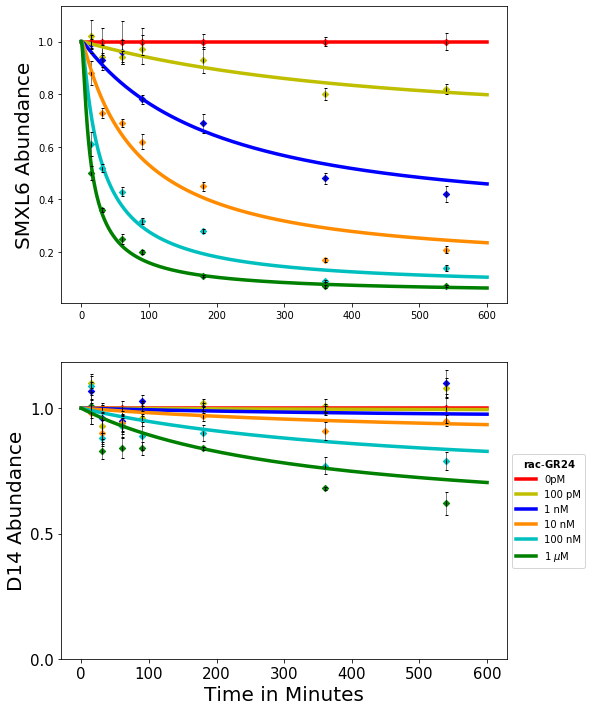

In [3]:
'''Simulation over time'''

#defining initial values


SL=0.
D14=1.
SMXL6=1.
SL_D14=0.

x0=[SL,D14,SMXL6,SL_D14]


T=np.linspace(0,600,1000)# declaring time steps





#list of corresponding treatment concentrations

realstringarray=['0pM','100 pM','1 nM','10 nM','100 nM','1 $\mu$M']


SL_x0_array=[0.,0.,0.,0.,         0.,0.]


#this list includes the 6 fitted parameters of SL_inf for the respective treatment concentrations
array=[0., 4.59531718e-01, 2.18759881e+00, 6.36056973e+00,
       1.96744158e+01, 4.33039934e+01]

colors=['r','y','b','darkorange','c','g']    #colors to connect simulations with respective data points
results=[]



fig=plt.figure(figsize=(8,12))
#simulating with different SL influxes
for j in range(len(array)):
    m.parameters['SL_inf']=array[j] #set the influx parameter


    s=Simulator(m)
    y0=np.array([SL_x0_array[j],D14,SMXL6,SL_D14])
    s.initialise(y0)

    t=np.linspace(0,600,600)
    
    s.simulate(600,steps=600)

    plt.subplot(211)
    plt.plot(s.get_time(),s.get_variable('SMXL6'),color=colors[j],label=realstringarray[j], linewidth=3.5) #plot only SMXL6 abundance
    plt.subplot(212)
    plt.plot(s.get_time(),s.get_variable('D14')+s.get_variable('SL_D14'),color=colors[j],label=realstringarray[j], linewidth=3.5)
    

plt.legend(loc='best')    
plt.subplot(211)    
plt.ylabel('SMXL6 Abundance',fontsize=20)
#plt.title('SMXL6',fontsize=20)
plt.subplot(212)
plt.ylabel('D14 Abundance',fontsize=20)


mark='D'
linewid=0.5
S=20


for i in range(len(time)):
    
    plt.subplot(211)
    plt.scatter(time[i],pm0[i],s=S,color='r',marker=mark)
    plt.errorbar(time[i],pm0[i], xerr=0., yerr=pm0_err[i],color='k',linewidth=linewid,capsize=1.5)
    plt.scatter(time[i],pm100[i],s=S,color='y',marker=mark)
    plt.errorbar(time[i],pm100[i], xerr=0., yerr=pm100_err[i],color='k',linewidth=linewid,capsize=1.5)
    
    plt.scatter(time[i],nm1[i],s=S,color='b',marker=mark)
    plt.errorbar(time[i],nm1[i], xerr=0., yerr=nm1_err[i],color='k',linewidth=linewid,capsize=1.5)
    
    plt.scatter(time[i],nm10[i],s=S,color='darkorange',marker=mark)
    plt.errorbar(time[i],nm10[i], xerr=0., yerr=nm10_err[i],color='k',linewidth=linewid,capsize=1.5)

    plt.scatter(time[i],nm100[i],s=S,color='c',marker=mark)
    plt.errorbar(time[i],nm100[i], xerr=0., yerr=nm100_err[i],color='k',linewidth=linewid,capsize=1.5)
    plt.scatter(time[i],um1[i],s=S,color='g',marker=mark)
    plt.errorbar(time[i],um1[i], xerr=0., yerr=um1_err[i],color='k',linewidth=linewid,capsize=1.5)
    

    
    
for i in range(len(time_d14)):

    plt.subplot(212)

    plt.scatter(time_d14[i],pm0_d14[i],s=S,color='r',marker=mark)
    plt.errorbar(time_d14[i],pm0_d14[i], xerr=0., yerr=pm0_err_d14[i],color='k',linewidth=linewid,capsize=1.5)
    
    plt.scatter(time_d14[i],pm100_d14[i],s=S,color='y',marker=mark)
    plt.errorbar(time_d14[i],pm100_d14[i], xerr=0., yerr=pm100_err_d14[i],color='k',linewidth=linewid,capsize=1.5)

    plt.scatter(time_d14[i],nm1_d14[i],s=S,color='b',marker=mark)
    plt.errorbar(time_d14[i],nm1_d14[i], xerr=0., yerr=nm1_err_d14[i],color='k',linewidth=linewid,capsize=1.5)

    plt.scatter(time_d14[i],nm10_d14[i],s=S,color='darkorange',marker=mark)
    plt.errorbar(time_d14[i],nm10_d14[i], xerr=0., yerr=nm10_err_d14[i],color='k',linewidth=linewid,capsize=1.5)

    plt.scatter(time_d14[i],nm100_d14[i],s=S,color='c',marker=mark)
    plt.errorbar(time_d14[i],nm100_d14[i], xerr=0., yerr=nm100_err_d14[i],color='k',linewidth=linewid,capsize=1.5)

    plt.scatter(time_d14[i],um1_d14[i],s=S,color='g',marker=mark)
    plt.errorbar(time_d14[i],um1_d14[i], xerr=0., yerr=um1_err_d14[i],color='k',linewidth=linewid,capsize=1.5)



plt.legend(loc='best')
plt.legend(loc='center left', bbox_to_anchor=(1., 0.5), prop={'size': 10},title=r'$\bf{rac}$-$\bf{GR24}$')

plt.xlabel('Time in Minutes',fontsize=20)
plt.yticks([0,0.5,1.],fontsize=15)
plt.xticks(fontsize=15)


plt.show()
# # #fig.savefig('SMXL6_plot_supp', bbox_inches='tight')

In [15]:
'''Simulation over time'''
%matplotlib qt

#defining initial values


SL=0.
D14=1.
SMXL6=1.
SL_D14=0.

x0=[SL,D14,SMXL6,SL_D14]


T=np.linspace(0,600,1000)# declaring time steps





#list of corresponding treatment concentrations

realstringarray=['0 pM','100 pM','1 nM','10 nM','100 nM','1 $\mu$M']


SL_x0_array=[0.,0.,0.,0.,         0.,0.]


#this list includes the 6 fitted parameters of SL_inf for the respective treatment concentrations
array=[0., 4.59531718e-01, 2.18759881e+00, 6.36056973e+00,
       1.96744158e+01, 4.33039934e+01]

colors=['r','y','b','darkorange','c','g']    #colors to connect simulations with respective data points
results=[]



fig=plt.figure(figsize=(8,12))
#simulating with different SL influxes
for j in range(len(array)):
    m.parameters['SL_inf']=array[j] #set the influx parameter


    s=Simulator(m)
    y0=np.array([SL_x0_array[j],D14,SMXL6,SL_D14])
    s.initialise(y0)

    t=np.linspace(0,600,600)
    
    s.simulate(600,steps=600)

    plt.subplot(211)
    plt.plot(s.get_time(),s.get_variable('SMXL6'),color=colors[j],label=realstringarray[j], linewidth=3.5) #plot only SMXL6 abundance
    plt.subplot(212)
    plt.plot(s.get_time(),s.get_variable('D14')+s.get_variable('SL_D14'),color=colors[j],label=realstringarray[j], linewidth=3.5)
    
#plt.legend(loc='best')    
plt.subplot(211)    
plt.ylabel('SMXL6 Abundance',fontsize=20)
#plt.title('SMXL6',fontsize=20)
plt.subplot(212)
plt.ylabel('D14 Abundance',fontsize=20)


mark='D'
linewid=0.5
S=20

#plotting the data
for i in range(len(time)):
    
    plt.subplot(211)
    plt.scatter(time[i],pm0[i],s=S,color='r',marker=mark)
    plt.errorbar(time[i],pm0[i], xerr=0., yerr=pm0_err[i],color='k',linewidth=linewid,capsize=1.5)
    plt.scatter(time[i],pm100[i],s=S,color='y',marker=mark)
    plt.errorbar(time[i],pm100[i], xerr=0., yerr=pm100_err[i],color='k',linewidth=linewid,capsize=1.5)
    
    plt.scatter(time[i],nm1[i],s=S,color='b',marker=mark)
    plt.errorbar(time[i],nm1[i], xerr=0., yerr=nm1_err[i],color='k',linewidth=linewid,capsize=1.5)
    
    plt.scatter(time[i],nm10[i],s=S,color='darkorange',marker=mark)
    plt.errorbar(time[i],nm10[i], xerr=0., yerr=nm10_err[i],color='k',linewidth=linewid,capsize=1.5)

    plt.scatter(time[i],nm100[i],s=S,color='c',marker=mark)
    plt.errorbar(time[i],nm100[i], xerr=0., yerr=nm100_err[i],color='k',linewidth=linewid,capsize=1.5)
    plt.scatter(time[i],um1[i],s=S,color='g',marker=mark)
    plt.errorbar(time[i],um1[i], xerr=0., yerr=um1_err[i],color='k',linewidth=linewid,capsize=1.5)
    

plt.legend(loc='best')
plt.legend(loc='center left', bbox_to_anchor=(1., 0.5), prop={'size': 10},title=r'$\bf{rac}$-$\bf{GR24}$')
    
    
for i in range(len(time_d14)):

    plt.subplot(212)

    plt.scatter(time_d14[i],pm0_d14[i],s=S,color='r',marker=mark)
    plt.errorbar(time_d14[i],pm0_d14[i], xerr=0., yerr=pm0_err_d14[i],color='k',linewidth=linewid,capsize=1.5)
    
    plt.scatter(time_d14[i],pm100_d14[i],s=S,color='y',marker=mark)
    plt.errorbar(time_d14[i],pm100_d14[i], xerr=0., yerr=pm100_err_d14[i],color='k',linewidth=linewid,capsize=1.5)

    plt.scatter(time_d14[i],nm1_d14[i],s=S,color='b',marker=mark)
    plt.errorbar(time_d14[i],nm1_d14[i], xerr=0., yerr=nm1_err_d14[i],color='k',linewidth=linewid,capsize=1.5)

    plt.scatter(time_d14[i],nm10_d14[i],s=S,color='darkorange',marker=mark)
    plt.errorbar(time_d14[i],nm10_d14[i], xerr=0., yerr=nm10_err_d14[i],color='k',linewidth=linewid,capsize=1.5)

    plt.scatter(time_d14[i],nm100_d14[i],s=S,color='c',marker=mark)
    plt.errorbar(time_d14[i],nm100_d14[i], xerr=0., yerr=nm100_err_d14[i],color='k',linewidth=linewid,capsize=1.5)

    plt.scatter(time_d14[i],um1_d14[i],s=S,color='g',marker=mark)
    plt.errorbar(time_d14[i],um1_d14[i], xerr=0., yerr=um1_err_d14[i],color='k',linewidth=linewid,capsize=1.5)




plt.xlabel('Minutes',fontsize=20)
#plt.yticks([0,0.5,1.],fontsize=15)
plt.xticks(fontsize=15)
#plt.xlim((-5,600))

plt.show()



Definition of an optimitation routine which returns the RMS of a parameterset after simulations. A penalty routine is included, increasing the RMS if D14 concentration is higher than 1. The optimization routine is used with the scipy.optimize.minimize function in order to return parametersets resulting in low RMS.
The resulting parameterset is used for another simulation and the results and data are plotted.

In [5]:
def penalty(x):
    #introducing a penalty function for values over 1
    if x<1:
        return 0
    else:
        return (x-1)

def optimize(p0):
    #listing and sorting data
    conc=[[1.00,	1.02,	0.99,	0.88,	0.61,	0.50],[1.00,	0.94	,0.93,	0.73,	0.52	,0.36],[1.00	,0.94,	0.96	,0.69	,0.43	,0.25],[1.00,	0.97	,0.78,	0.62,	0.32,	0.20],[1.00, 0.93 ,0.69, 0.45 ,0.28 ,0.11],[1.00,	0.80	,0.48,	0.17	,0.09,	0.07],[1.00 ,0.82 ,0.42, 0.21, 0.14 ,0.07]]
    conc=np.array(conc)


    conc_d14=[[1.00,	1.01	,0.98,	0.96	,0.93	,0.95],
              
              [1.00,1.04,0.95,0.91,0.90,0.88],
              
              [1.00,0.93,0.98,0.91,0.83,0.75],
              
              [1.00,1.07,1.06,0.98,0.84,0.74]]
    conc_d14=np.array(conc_d14)
    
    
    
    data0=[]
    data1=[]
    data2=[]
    data3=[]
    data4=[]
    data5=[]
  
    
    time=[15.,30.,60.,90.,180.,360.,540]
    time_d14=[15.,180.,360.,540]
    
    for i in range(len(time)):
        data0.append(conc[i,0])
        data1.append(conc[i,1])
        data2.append(conc[i,2])
        data3.append(conc[i,3])
        data4.append(conc[i,4])
        data5.append(conc[i,5])
        
    data0_d14=[]
    data1_d14=[]
    data2_d14=[]
    data3_d14=[]
    data4_d14=[]
    data5_d14=[]
  
    

    
    for i in range(len(time_d14)):
        data0_d14.append(conc_d14[i,0])
        data1_d14.append(conc_d14[i,1])
        data2_d14.append(conc_d14[i,2])
        data3_d14.append(conc_d14[i,3])
        data4_d14.append(conc_d14[i,4])
        data5_d14.append(conc_d14[i,5])


#    inf0,inf1,inf2,inf3,inf4,inf5, x.par.SL_D14_TO,x.par.SL_D53_TO,x.par.SL_eff,x.par.SL_ka,x.par.SL_lm,x.par.recycle,x.par.turnover=p0

    #unpack parameters from p0 into corresponding dictionary keys
    inf0,inf1,inf2,inf3,inf4,inf5=p0[0:6]
    
    
    m.parameters['SL_D14_TO']=p0[6]
    m.parameters['SL_SMXL6_TO']=p0[7]
    m.parameters['SL_eff']=p0[8]
    m.parameters['SL_ka']=p0[9]
    m.parameters['SL_lm']=p0[10]
    m.parameters['recycle']=p0[11]
    m.parameters['turnover']=p0[12]
    

    #every SL treatment concentration, and therefore fitted SL influx, is simulated seperately
    m.parameters['SL_inf']=inf0
    s0=Simulator(m)
    y0=np.array([SL_x0_array[0],D14,SMXL6,SL_D14])
    s0.initialise(y0)
    s0.simulate(600,steps=599)
    ss0=s0.get_variable('D14')[-1]+s0.get_variable('SL_D14')[-1]
    

    
    m.parameters['SL_inf']=inf1
    s1=Simulator(m)
    y0=np.array([SL_x0_array[1],D14,SMXL6,SL_D14])
    s1.initialise(y0)
    s1.simulate(600,steps=599)
    
    
    
    ss1=s1.get_variable('D14')[-1]+s1.get_variable('SL_D14')[-1]
    
    m.parameters['SL_inf']=inf2
    s2=Simulator(m)
    y0=np.array([SL_x0_array[2],D14,SMXL6,SL_D14])
    s2.initialise(y0)
    s2.simulate(600,steps=599)
    
    ss2=s2.get_variable('D14')[-1]+s2.get_variable('SL_D14')[-1]
    
    
    m.parameters['SL_inf']=inf3
    s3=Simulator(m)
    y0=np.array([SL_x0_array[3],D14,SMXL6,SL_D14])
    s3.initialise(y0)
    s3.simulate(600,steps=599)
    ss3=s3.get_variable('D14')[-1]+s3.get_variable('SL_D14')[-1]

    m.parameters['SL_inf']=inf4
    s4=Simulator(m)
    y0=np.array([SL_x0_array[4],D14,SMXL6,SL_D14])
    s4.initialise(y0)
    s4.simulate(600,steps=599)
    ss4=s4.get_variable('D14')[-1]+s4.get_variable('SL_D14')[-1]

    m.parameters['SL_inf']=inf5
    s5=Simulator(m)
    y0=np.array([SL_x0_array[5],D14,SMXL6,SL_D14])
    s5.initialise(y0)
    s5.simulate(600,steps=599)
    ss5=s5.get_variable('D14')[-1]+s5.get_variable('SL_D14')[-1]

    # The RMS is calculated from the simulation results (using the current parameterset) and the respective data
    RSM=0
    for i in range(len(time)):


        RSM+= (data0[i]-s0.get_variable('SMXL6')[int(time[i])])**2 + (data1[i]-s1.get_variable('SMXL6')[int(time[i])])**2 + (data2[i]-s2.get_variable('SMXL6')[int(time[i])])**2 + (data3[i]-s3.get_variable('SMXL6')[int(time[i])])**2 + (data4[i]-s4.get_variable('SMXL6')[int(time[i])])**2+ (data5[i]-s5.get_variable('SMXL6')[int(time[i])])**2



    for i in range(len(time_d14)):
        RSM+= (data0_d14[i]-s0.get_variable('D14')[int(time[i])])**2 + (data1_d14[i]-s1.get_variable('D14')[int(time[i])])**2 + (data2_d14[i]-s2.get_variable('D14')[int(time[i])])**2 + (data3_d14[i]-s3.get_variable('D14')[int(time[i])])**2 + (data4_d14[i]-s4.get_variable('D14')[int(time[i])])**2+ (data5_d14[i]-s5.get_variable('D14')[int(time[i])])**2



    
    rootmeansquare=np.sqrt(RSM)
    
    print('rms '+str(rootmeansquare))
#    
    pen = penalty(ss0)+penalty(ss1)+penalty(ss2)+penalty(ss3)+penalty(ss4)+penalty(ss5)
#    
    score= rootmeansquare+pen
    print(rootmeansquare,pen)
    
    return score


#defining an initial guess

init_guess=[0., 4.59531729e-01, 2.18759887e+00, 6.36057084e+00,
        1.96744152e+01, 4.33039933e+01,1.58533423e+01, 4.02114432e-01,1.00000000e-03,1.00000000e-03,
         4.08586935e+01,1.56663361e+01,4.83259518e+01]

#defining the lower and upper bounds for all parameters
LB=0.001
UB=50

bound=((0.,UB),(LB,UB),(LB,UB),(LB,UB),(LB,UB),(LB,UB),(LB,UB),(LB,UB),(LB,UB),(LB,UB),(LB,UB),(LB,UB),(LB,UB))

#creating a list of random parameters
randomlist=np.linspace(0.001,10,20)

#exchange parameters from the initial guess with randomly selected ones
#for i in range(len(init_guess)):
#    init_guess[i]=random.choice(randomlist)
    
#or, optionally, choose a preselected set
init_guess=[0., 0.0001 , 0.0005 , 0.0012 , 0.00175 , 0.0026,0.005,0.001,0.1,10.,0.9,0.07,1.]

#performing a single optimization routine

fit=scipy.optimize.minimize(optimize,init_guess,bounds=bound)

rms 2.2319630219793027
2.2319630219793027 0.0
rms 2.231963021984255
2.231963021984255 0
rms 2.2319632293929312
2.2319632293929312 0.0
rms 2.2319623575884884
2.2319623575884884 0.0
rms 2.2319617448584013
2.2319617448584013 0.0
rms 2.2319617094326483
2.2319617094326483 0.0
rms 2.231961890786774
2.231961890786774 0.0
rms 2.231963021773757
2.231963021773757 0.0
rms 2.231964205844679
2.231964205844679 0.0
rms 2.2319630179566796
2.2319630179566796 0.0
rms 2.231963022181522
2.231963022181522 0.0
rms 2.231963014901221
2.231963014901221 0.0
rms 2.231963029372041
2.231963029372041 0.0
rms 2.2319630291112773
2.2319630291112773 0.0
rms 4.747354631468331
4.747354631468331 0.0
rms 4.747354631557208
4.747354631557208 0
rms 4.747355920488438
4.747355920488438 0.0
rms 4.747354627341259
4.747354627341259 0.0
rms 4.747354627760711
4.747354627760711 0.0
rms 4.7473546287819675
4.7473546287819675 0.0
rms 4.747354629219521
4.747354629219521 0.0
rms 4.747354639626401
4.747354639626401 0.0
rms 4.74735415345783

rms 1.2031096085623922
1.2031096085623922 0.0
rms 1.2031089455763355
1.2031089455763355 0.0
rms 1.20310918657563
1.20310918657563 0.0
rms 1.2031091961188205
1.2031091961188205 0.0
rms 1.2031091798430513
1.2031091798430513 0.0
rms 1.2031090558950153
1.2031090558950153 0.0
rms 1.2031099309730229
1.2031099309730229 0.0
rms 1.20310924421606
1.20310924421606 0.0
rms 1.2031092149262346
1.2031092149262346 0.0
rms 1.2031092355260211
1.2031092355260211 0.0
rms 1.2031092396234861
1.2031092396234861 0.0
rms 1.20310924518038
1.20310924518038 0.0
rms 1.1181140577312898
1.1181140577312898 0.0
rms 1.118114057740956
1.118114057740956 0
rms 1.11811442229946
1.11811442229946 0.0
rms 1.1181135008237704
1.1181135008237704 0.0
rms 1.1181136740686057
1.1181136740686057 0.0
rms 1.1181140582380658
1.1181140582380658 0.0
rms 1.118114066346008
1.118114066346008 0.0
rms 1.118113899025254
1.118113899025254 0.0
rms 1.11811474784772
1.11811474784772 0.0
rms 1.1181140469819904
1.1181140469819904 0.0
rms 1.1181139768

rms 0.4686816076720679
0.4686816076720679 0
rms 0.4686816699486281
0.4686816699486281 0.0
rms 0.4686815324042635
0.4686815324042635 0.0
rms 0.46868156987090953
0.46868156987090953 0.0
rms 0.4686815893393689
0.4686815893393689 0.0
rms 0.46868161742313086
0.46868161742313086 0.0
rms 0.4686816061164638
0.4686816061164638 0.0
rms 0.4686818025999004
0.4686818025999004 0.0
rms 0.46868160769908784
0.46868160769908784 0.0
rms 0.468681580097779
0.468681580097779 0.0
rms 0.46868160662839115
0.46868160662839115 0.0
rms 0.468681608055875
0.468681608055875 0.0
rms 0.4686816084680492
0.4686816084680492 0.0
rms 0.4729791521118248
0.4729791521118248 0.0
rms 0.47297915212348995
0.47297915212348995 0
rms 0.4729792060622006
0.4729792060622006 0.0
rms 0.47297916053269423
0.47297916053269423 0.0
rms 0.47297910393968945
0.47297910393968945 0.0
rms 0.4729791655267303
0.4729791655267303 0.0
rms 0.47297916556561814
0.47297916556561814 0.0
rms 0.4729791526529969
0.4729791526529969 0.0
rms 0.47297922704551204
0.

rms 0.464357315152841
0.464357315152841 0.0
rms 0.46435731525955287
0.46435731525955287 0.0
rms 0.464357315389834
0.464357315389834 0.0
rms 0.46411502045798453
0.46411502045798453 0.0
rms 0.46411502047136727
0.46411502047136727 0
rms 0.4641151730457629
0.4641151730457629 0.0
rms 0.46411500189195326
0.46411500189195326 0.0
rms 0.46411503229889556
0.46411503229889556 0.0
rms 0.4641150115631433
0.4641150115631433 0.0
rms 0.46411502487192396
0.46411502487192396 0.0
rms 0.46411502027417595
0.46411502027417595 0.0
rms 0.46411501787996523
0.46411501787996523 0.0
rms 0.46411502043460556
0.46411502043460556 0.0
rms 0.46411501620042783
0.46411501620042783 0.0
rms 0.46411502042183495
0.46411502042183495 0.0
rms 0.4641150202618885
0.4641150202618885 0.0
rms 0.4641150204038163
0.4641150204038163 0.0
rms 0.46394943673044314
0.46394943673044314 0.0
rms 0.4639494367437369
0.4639494367437369 0
rms 0.46394959592922475
0.46394959592922475 0.0
rms 0.46394943558349055
0.46394943558349055 0.0
rms 0.46394943

rms 0.46368080451157345
0.46368080451157345 0.0
rms 0.4636808031148265
0.4636808031148265 0.0
rms 0.4636807996529652
0.4636807996529652 0.0
rms 0.4636808326619345
0.4636808326619345 0.0
rms 0.4636808045098658
0.4636808045098658 0.0
rms 0.4636808042422673
0.4636808042422673 0.0
rms 0.46368080434276426
0.46368080434276426 0.0
rms 0.46368004173405497
0.46368004173405497 0.0
rms 0.46368004174724137
0.46368004174724137 0
rms 0.4636801866040906
0.4636801866040906 0.0
rms 0.4636800314140355
0.4636800314140355 0.0
rms 0.4636800331204366
0.4636800331204366 0.0
rms 0.46368004097035015
0.46368004097035015 0.0
rms 0.46368004615067143
0.46368004615067143 0.0
rms 0.4636800417865773
0.4636800417865773 0.0
rms 0.4636800403558448
0.4636800403558448 0.0
rms 0.46368004170997074
0.46368004170997074 0.0
rms 0.46368003187015444
0.46368003187015444 0.0
rms 0.4636800417753928
0.4636800417753928 0.0
rms 0.4636800415175162
0.4636800415175162 0.0
rms 0.46368004163450627
0.46368004163450627 0.0
rms 0.463679836531

rms 0.4636263981155141
0.4636263981155141 0.0
rms 0.46362625311428635
0.46362625311428635 0.0
rms 0.4636262437374305
0.4636262437374305 0.0
rms 0.46362624478828574
0.46362624478828574 0.0
rms 0.4636262436523327
0.4636262436523327 0.0
rms 0.4636262440486025
0.4636262440486025 0.0
rms 0.46362624304003247
0.46362624304003247 0.0
rms 0.46362624423054727
0.46362624423054727 0.0
rms 0.4636262431336904
0.4636262431336904 0.0
rms 0.4636262440375414
0.4636262440375414 0.0
rms 0.4636262437213804
0.4636262437213804 0.0
rms 0.4636262438125167
0.4636262438125167 0.0
rms 0.4636242687959138
0.4636242687959138 0.0
rms 0.4636242688090348
0.4636242688090348 0
rms 0.46362441141630123
0.46362441141630123 0.0
rms 0.4636242891910301
0.4636242891910301 0.0
rms 0.46362426837997667
0.46362426837997667 0.0
rms 0.46362426945097307
0.46362426945097307 0.0
rms 0.4636242685669252
0.4636242685669252 0.0
rms 0.4636242688773723
0.4636242688773723 0.0
rms 0.463624268348572
0.463624268348572 0.0
rms 0.46362426877115787


rms 0.46362230284257305
0.46362230284257305 0.0
rms 0.46362230293484896
0.46362230293484896 0.0
rms 0.4636223246338727
0.4636223246338727 0.0
rms 0.4636223246470126
0.4636223246470126 0
rms 0.46362246638049176
0.46362246638049176 0.0
rms 0.46362230907193336
0.46362230907193336 0.0
rms 0.46362232363772216
0.46362232363772216 0.0
rms 0.46362233501904376
0.46362233501904376 0.0
rms 0.46362232026905303
0.46362232026905303 0.0
rms 0.46362232469951625
0.46362232469951625 0.0
rms 0.4636223260959101
0.4636223260959101 0.0
rms 0.46362232460962866
0.46362232460962866 0.0
rms 0.46362232859633346
0.46362232859633346 0.0
rms 0.4636223246833156
0.4636223246833156 0.0
rms 0.4636223244163156
0.4636223244163156 0.0
rms 0.46362232450490026
0.46362232450490026 0.0
rms 0.46362231713473046
0.46362231713473046 0.0
rms 0.4636223171478704
0.4636223171478704 0
rms 0.46362246519724326
0.46362246519724326 0.0
rms 0.4636223133549491
0.4636223133549491 0.0
rms 0.4636223161402806
0.4636223161402806 0.0
rms 0.463622

rms 0.46362200337871456
0.46362200337871456 0.0
rms 0.4636220041078762
0.4636220041078762 0.0
rms 0.4636220021868684
0.4636220021868684 0.0
rms 0.46362200418875127
0.46362200418875127 0.0
rms 0.46362200390832414
0.46362200390832414 0.0
rms 0.463622003997416
0.463622003997416 0.0
rms 0.46362195320406646
0.46362195320406646 0.0
rms 0.46362195321722577
0.46362195321722577 0
rms 0.4636221049555523
0.4636221049555523 0.0
rms 0.4636219676882682
0.4636219676882682 0.0
rms 0.46362195493032365
0.46362195493032365 0.0
rms 0.4636219499820482
0.4636219499820482 0.0
rms 0.46362195330046685
0.46362195330046685 0.0
rms 0.4636219532803356
0.4636219532803356 0.0
rms 0.46362195253670646
0.46362195253670646 0.0
rms 0.4636219531798492
0.4636219531798492 0.0
rms 0.46362196526350075
0.46362196526350075 0.0
rms 0.4636219532603023
0.4636219532603023 0.0
rms 0.46362195296073383
0.46362195296073383 0.0
rms 0.46362195306981463
0.46362195306981463 0.0
rms 0.4636219485083189
0.4636219485083189 0.0
rms 0.4636219485

rms 0.463621963140933
0.463621963140933 0.0
rms 0.46362194791355904
0.46362194791355904 0.0
rms 0.4636219549220847
0.4636219549220847 0.0
rms 0.46362194860923034
0.46362194860923034 0.0
rms 0.4636219485816827
0.4636219485816827 0.0
rms 0.46362194792086764
0.46362194792086764 0.0
rms 0.4636219476122189
0.4636219476122189 0.0
rms 0.46362195484439717
0.46362195484439717 0.0
rms 0.4636219485612452
0.4636219485612452 0.0
rms 0.4636219482835481
0.4636219482835481 0.0
rms 0.4636219483736368
0.4636219483736368 0.0
rms 0.4636219485083189
0.4636219485083189 0.0
rms 0.4636219485214774
0.4636219485214774 0
rms 0.4636220945322529
0.4636220945322529 0.0
rms 0.46362196314262544
0.46362196314262544 0.0
rms 0.4636219479135102
0.4636219479135102 0.0
rms 0.4636219549220359
0.4636219549220359 0.0
rms 0.46362194860918154
0.46362194860918154 0.0
rms 0.4636219485828019
0.4636219485828019 0.0
rms 0.46362194791977884
0.46362194791977884 0.0
rms 0.46362194763210185
0.46362194763210185 0.0
rms 0.4636219548423430

rms 0.4639942268186668
0.4639942268186668 0.0
rms 0.4639942269060013
0.4639942269060013 0.0
rms 0.46365347808420443
0.46365347808420443 0.0
rms 0.4636534780972094
0.4636534780972094 0
rms 0.46365361395192417
0.46365361395192417 0.0
rms 0.4636534719528173
0.4636534719528173 0.0
rms 0.4636534747558188
0.4636534747558188 0.0
rms 0.46365347055965095
0.46365347055965095 0.0
rms 0.46365346663308005
0.46365346663308005 0.0
rms 0.4636534781643889
0.4636534781643889 0.0
rms 0.46365349740235595
0.46365349740235595 0.0
rms 0.46365347297449533
0.46365347297449533 0.0
rms 0.4636534665532951
0.4636534665532951 0.0
rms 0.4636534780364694
0.4636534780364694 0.0
rms 0.46365347795708517
0.46365347795708517 0.0
rms 0.46365347803547613
0.46365347803547613 0.0
rms 0.46362800945701593
0.46362800945701593 0.0
rms 0.4636280094701008
0.4636280094701008 0
rms 0.4636281542831453
0.4636281542831453 0.0
rms 0.46362800244580893
0.46362800244580893 0.0
rms 0.463628008566273
0.463628008566273 0.0
rms 0.46362800897638

rms 0.46362174699147024
0.46362174699147024 0.0
rms 0.4636217520656822
0.4636217520656822 0.0
rms 0.46362174071975143
0.46362174071975143 0.0
rms 0.4636217404227554
0.4636217404227554 0.0
rms 0.46362174053373795
0.46362174053373795 0.0
rms 0.463621751257666
0.463621751257666 0.0
rms 0.4636217512708172
0.4636217512708172 0
rms 0.4636218982335856
0.4636218982335856 0.0
rms 0.4636217441810815
0.4636217441810815 0.0
rms 0.4636217530988031
0.4636217530988031 0.0
rms 0.4636217576230192
0.4636217576230192 0.0
rms 0.46362175134295713
0.46362175134295713 0.0
rms 0.46362175132950334
0.46362175132950334 0.0
rms 0.4636217511661712
0.4636217511661712 0.0
rms 0.4636217457225252
0.4636217457225252 0.0
rms 0.46362173813546914
0.46362173813546914 0.0
rms 0.4636217513111209
0.4636217513111209 0.0
rms 0.46362175103655345
0.46362175103655345 0.0
rms 0.4636217510524702
0.4636217510524702 0.0
rms 0.46362172722841916
0.46362172722841916 0.0
rms 0.4636217272415703
0.4636217272415703 0
rms 0.463621876056168
0.

rms 0.463621731238867
0.463621731238867 0.0
rms 0.46362173359366204
0.46362173359366204 0.0
rms 0.46362172731360074
0.46362172731360074 0.0
rms 0.46362172737322566
0.46362172737322566 0.0
rms 0.46362172728299744
0.46362172728299744 0.0
rms 0.4636217335517823
0.4636217335517823 0.0
rms 0.4636217163487911
0.4636217163487911 0.0
rms 0.46362172735592494
0.46362172735592494 0.0
rms 0.4636217270787048
0.4636217270787048 0.0
rms 0.463621727168113
0.463621727168113 0.0
rms 0.46362172722830575
0.46362172722830575 0.0
rms 0.46362172724145695
0.46362172724145695 0
rms 0.4636218760560545
0.4636218760560545 0.0
rms 0.46362174193524064
0.46362174193524064 0.0
rms 0.463621731238867
0.463621731238867 0.0
rms 0.46362173359366204
0.46362173359366204 0.0
rms 0.46362172731360074
0.46362172731360074 0.0
rms 0.46362172737322566
0.46362172737322566 0.0
rms 0.46362172728299744
0.46362172728299744 0.0
rms 0.4636217335517823
0.4636217335517823 0.0
rms 0.4636217163487911
0.4636217163487911 0.0
rms 0.463621727355

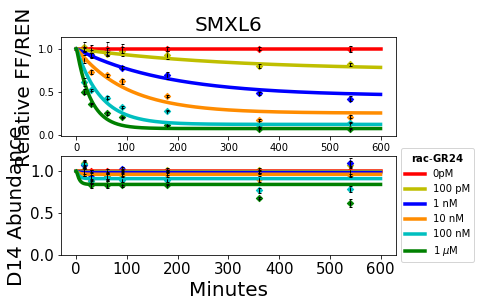

In [6]:
#unpacking and plotting simulation results with the resulting fitted parameter set
m.parameters['SL_D14_TO']=fit.x[6]
m.parameters['SL_SMXL6_TO']=fit.x[7]
m.parameters['SL_eff']=fit.x[8]
m.parameters['SL_ka']=fit.x[9]
m.parameters['SL_lm']=fit.x[10]
m.parameters['recycle']=fit.x[11]
m.parameters['turnover']=fit.x[12]


cnt=0
for j in fit.x[0:6]:
    m.parameters['SL_inf']=j #set the influx parameter


    s=Simulator(m)
    y0=np.array([SL_x0_array[cnt],D14,SMXL6,SL_D14])
    s.initialise(y0)

    t=np.linspace(0,600,600)
    
    s.simulate(600,steps=600)
    
    
    
    plt.subplot(211)
    plt.plot(s.get_time(),s.get_variable('SMXL6'),color=colors[cnt],label=realstringarray[cnt], linewidth=3.5) #plot only SMXL6 abundance
    plt.subplot(212)
    plt.plot(s.get_time(),s.get_variable('D14')+s.get_variable('SL_D14'),color=colors[cnt],label=realstringarray[cnt], linewidth=3.5)
    cnt+=1


plt.legend(loc='best')    
plt.subplot(211)    
plt.ylabel('Relative FF/REN',fontsize=20)
plt.title('SMXL6',fontsize=20)
plt.subplot(212)
plt.ylabel('D14 Abundance',fontsize=20)


mark='D'
linewid=0.5
S=20


for i in range(len(time)):
    
    plt.subplot(211)
    plt.scatter(time[i],pm0[i],s=S,color='r',marker=mark)
    plt.errorbar(time[i],pm0[i], xerr=0., yerr=pm0_err[i],color='k',linewidth=linewid,capsize=1.5)
    plt.scatter(time[i],pm100[i],s=S,color='y',marker=mark)
    plt.errorbar(time[i],pm100[i], xerr=0., yerr=pm100_err[i],color='k',linewidth=linewid,capsize=1.5)
    
    plt.scatter(time[i],nm1[i],s=S,color='b',marker=mark)
    plt.errorbar(time[i],nm1[i], xerr=0., yerr=nm1_err[i],color='k',linewidth=linewid,capsize=1.5)
    
    plt.scatter(time[i],nm10[i],s=S,color='darkorange',marker=mark)
    plt.errorbar(time[i],nm10[i], xerr=0., yerr=nm10_err[i],color='k',linewidth=linewid,capsize=1.5)

    plt.scatter(time[i],nm100[i],s=S,color='c',marker=mark)
    plt.errorbar(time[i],nm100[i], xerr=0., yerr=nm100_err[i],color='k',linewidth=linewid,capsize=1.5)
    plt.scatter(time[i],um1[i],s=S,color='g',marker=mark)
    plt.errorbar(time[i],um1[i], xerr=0., yerr=um1_err[i],color='k',linewidth=linewid,capsize=1.5)
    

    
    
for i in range(len(time_d14)):

    plt.subplot(212)

    plt.scatter(time_d14[i],pm0_d14[i],s=S,color='r',marker=mark)
    plt.errorbar(time_d14[i],pm0_d14[i], xerr=0., yerr=pm0_err_d14[i],color='k',linewidth=linewid,capsize=1.5)
    
    plt.scatter(time_d14[i],pm100_d14[i],s=S,color='y',marker=mark)
    plt.errorbar(time_d14[i],pm100_d14[i], xerr=0., yerr=pm100_err_d14[i],color='k',linewidth=linewid,capsize=1.5)

    plt.scatter(time_d14[i],nm1_d14[i],s=S,color='b',marker=mark)
    plt.errorbar(time_d14[i],nm1_d14[i], xerr=0., yerr=nm1_err_d14[i],color='k',linewidth=linewid,capsize=1.5)

    plt.scatter(time_d14[i],nm10_d14[i],s=S,color='darkorange',marker=mark)
    plt.errorbar(time_d14[i],nm10_d14[i], xerr=0., yerr=nm10_err_d14[i],color='k',linewidth=linewid,capsize=1.5)

    plt.scatter(time_d14[i],nm100_d14[i],s=S,color='c',marker=mark)
    plt.errorbar(time_d14[i],nm100_d14[i], xerr=0., yerr=nm100_err_d14[i],color='k',linewidth=linewid,capsize=1.5)

    plt.scatter(time_d14[i],um1_d14[i],s=S,color='g',marker=mark)
    plt.errorbar(time_d14[i],um1_d14[i], xerr=0., yerr=um1_err_d14[i],color='k',linewidth=linewid,capsize=1.5)






plt.legend(loc='best')
plt.legend(loc='center left', bbox_to_anchor=(1., 0.5), prop={'size': 10},title=r'$\bf{rac}$-$\bf{GR24}$')

plt.xlabel('Minutes',fontsize=20)
plt.yticks([0,0.5,1.],fontsize=15)
plt.xticks(fontsize=15)
#plt.xlim((-5,600))

plt.show()




In order to avoid local optima, the optimization routine is used 500 times with random parameters. A random seed is used in order to ensure reproducibility. The resulting RMS and parameterset are captured in lists and plotted for evaluation.

In [ ]:
#defining lists to capture results
big_speicher=[]
speicher=[]
funs=[]
#defining random seed for reproducibility
np.random.seed(0)
#performing 500 optimizations using randomly selected initial guesses
for n in range(500):
    randomlist=np.linspace(0.001,10,20)
    
    
    for i in range(len(init_guess)):
        init_guess[i]=random.choice(randomlist)
        

    
    fit=scipy.optimize.minimize(optimize,init_guess,bounds=bound)
    
    big_speicher.append(fit.x)
    funs.append(fit.fun)


# import pickle
# pickle.dump( big_speicher, open( "brandnewfits.p", "wb" ) )
# pickle.dump( funs, open( "brandnewlfuns.p", "wb" ) )




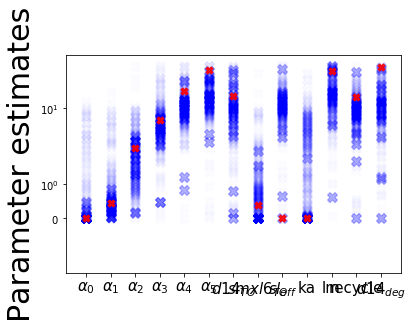

In [4]:


import pickle
speicher=pickle.load( open( "parameter_scans/brandnewfits.p", "rb" ) )
funz=pickle.load( open( "parameter_scans/brandnewlfuns.p", "rb" ) )



#visualizing the results of the parameter scan

fig=plt.figure()
ax= fig.add_subplot(111)

parnames=[r'$\alpha_0$',r'$\alpha_1$',r'$\alpha_2$',r'$\alpha_3$',r'$\alpha_4$',r'$\alpha_5$', r'$d14_{TO}$',r'$smxl6_{TO}$',r'$sl_{eff}$','ka','lm','recycle',r'$d14_{deg}$']
mypars = [0.00000000e+00, 4.59531718e-01, 2.18759881e+00, 6.36056973e+00,
        1.96744158e+01, 4.33039934e+01, 1.58533433e+01, 4.02115066e-01,
        1.00000000e-03, 1.05731710e-03, 4.08586938e+01, 1.56663368e+01,
        4.83259535e+01]

#adjusting transparency for parametersets with RMS above/under 0.7
for i in range(len(speicher)):
    if funz[i]>0.7:
        ax.scatter(parnames,speicher[i],s=100,color='b',marker='X',alpha=0.01)
    else:
        ax.scatter(parnames,speicher[i],s=100,color='b',marker='X',alpha=0.3)
        
    
    
    
ax.tick_params('x',labelsize=15.)
plt.scatter(parnames,mypars,s=50,color='r',marker='X',alpha=0.9)
plt.yscale('symlog')
plt.ylabel('Parameter estimates',fontsize=30)
plt.show()


